Dcgan
=====



[https://keras.io/examples/generative/dcgan_overriding_train_step/](https://keras.io/examples/generative/dcgan_overriding_train_step/)

To run this you will need gdown



In [1]:
!pip install gdown


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Reshape, Dropout, Dense,
                                     Flatten, BatchNormalization,
                                     Activation, ZeroPadding2D, LeakyReLU,
                                     UpSampling2D, Conv2D)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare Celeb data



In this example we will use the Celeb dataset. We will resize images to a size of `64x64`.
First download the dataset (only need to do this once, then it will throw an error but don&rsquo;t worry):



In [2]:
os.makedirs("datasets/celeba_gan", exist_ok=False)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "datasets/celeba_gan/data.zip"
gdown.download(url, output, quiet=False)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("datasets/celeba_gan")

FileExistsError: [Errno 17] File exists: 'datasets/celeba_gan'

And then convert this to a Tensorflow dataset. Because we expect to be training on our laptops, we will reduce the size of the training set. This is not ideal for GANs, but it will still produce reasonable results. Here we also scale the inputs to the `[-1, 1]` range and make sure the dataset is subdivided into batches of the desired size



In [3]:
image_size = 64 # images are square
image_channels = 3 # 3 RGB 1 Grayscale
image_shape = (image_size, image_size, image_channels)
dataset_size = 200
batch_size = 32

dataset = keras.utils.image_dataset_from_directory(
    "datasets/celeba_gan", label_mode=None, image_size=(image_size, image_size), batch_size=None)

dataset = dataset.take(dataset_size)
dataset = dataset.map(lambda x: x / 127.5 - 1.0)
dataset = dataset.batch(batch_size) # We create batch here since "take" would unbatch it..

Found 202599 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now let&rsquo;s see one random instance from the dataset:

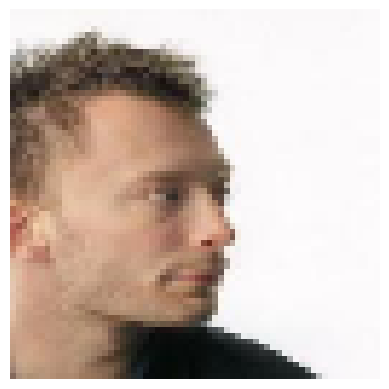

In [5]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 + 127.5).astype("int32")[0])
    break

## Create generator



At this staget we need to construct our generator. There are many implementations out there, this is one that works reasonably well for our use case and it is adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).
For GAN models it is [recommended](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/) to initialize the layers with normally distributed (Gaussian) values and standard deviation of 0.02. The following function is built to enable training on different image sizes, but we recommend sticking with the `64x64` image size:



In [35]:
kernel_size = 3
latent_dim = 100 # The size of the latent space

init = lambda: tf.keras.initializers.RandomNormal(stddev=0.02)

def build_generator():
    # From https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py
    # This block of code can be a little daunting, but essentially it automatically calculates the required starting
    # array size that will be correctly upscaled to our desired image size.
    #
    # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
    # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
    # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
    # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
    model = Sequential()
    upsample_layers = 5
    starting_filters = 128
    start_size = image_size // (2 ** upsample_layers)
    model.add(Dense(starting_filters * start_size * start_size, activation="relu", input_dim=latent_dim))
    model.add(Reshape((start_size, start_size, starting_filters)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 6x8 -> 12x16
    model.add(Conv2D(1024, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 12x16 -> 24x32
    model.add(Conv2D(512, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 24x32 -> 48x64
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 48x64 -> 96x128
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 96x128 -> 192x256
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(32, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(image_channels, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

generator = build_generator()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               51712     
                                                                 
 reshape_5 (Reshape)         (None, 2, 2, 128)         0         
                                                                 
 batch_normalization_45 (Bat  (None, 2, 2, 128)        512       
 chNormalization)                                                
                                                                 
 up_sampling2d_25 (UpSamplin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 4, 4, 1024)        1180672   
                                                                 
 activation_35 (Activation)  (None, 4, 4, 1024)      

Let&rsquo;s see it&rsquo;s output before training



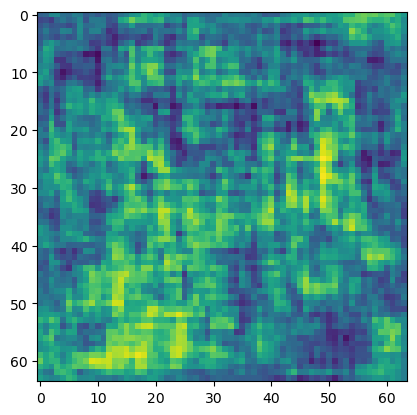

In [25]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=True)
plt.imshow(generated_image[0, :, :, 0])
plt.show()

## Create discriminator



We then define the discriminator model, again adapted adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).



In [36]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, input_shape=image_shape, padding="same", kernel_initializer=init()))  # 192x256 -> 96x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same", kernel_initializer=init()))  # 96x128 -> 48x64
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same", kernel_initializer=init()))  # 48x64 -> 24x32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(256, kernel_size=kernel_size, strides=1, padding="same", kernel_initializer=init()))  # 24x32 -> 12x16
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=kernel_size, strides=1, padding="same", kernel_initializer=init()))  # 12x16 -> 6x8
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=image_shape)
    validity = model(img)

    return Model(img, validity)

discriminator = build_discriminator()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_25 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 17, 17, 64)        0         
                                                     

Let&rsquo;s see what the discriminator thinks of our generated image:



In [9]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49969378]], shape=(1, 1), dtype=float32)


## Override `train_step`



Tensorflow and Keras offer many ways to combine the generator and discriminator into a GAN model and train it. Here we define a custom model class that overrides the `train_step` method, and define a custom loss function for the discriminator that adds smoothing to improve the convergence of the model.



In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator


    def generator_loss(self,fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)


    # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output):
        # This version adds noise as suggested in the official Keras DCGAN example
        noise_amt = 0.01
        real_loss = cross_entropy(tf.ones_like(real_output)+tf.random.uniform(tf.shape(real_output))*noise_amt,
                                  real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output)+tf.random.uniform(tf.shape(fake_output))*noise_amt,
                                  fake_output)

        # This version adds one sided smoothing
        # label for real image is (1-smooth)
        # smooth = 0.01
        # real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output)
        # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        # This version does the usual loss
        # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        return real_loss + fake_loss

    def compile(self,generator_optimizer,discriminator_optimizer):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function # This improves performance
    def train_step(self,data):
        # Standard procedure to recover batch size
        batch_size = tf.shape(data)[0]

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size, latent_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # generate image using generator
            generated_image = self.generator(seed, training=True)
            # discriminator's prediction for real image
            real_output = self.discriminator(data, training=True)

            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image, training=True)

            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,
                                                         self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,
                                                             self.discriminator.trainable_variables))

        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

## Create callback that periodically saves generated images



We want to visualize the results every epoch and save the resulting model and this Python class will take care of that automatically. The images and models will be saved in a specified directory. Periodically check the directory to see how the results change at each epoch.



In [28]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim, path):
        os.makedirs(path, exist_ok=True)
        self.path = path
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        #generated_images *= 255
        generated_images = generated_images * 127.5 + 127.5 #255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(self.path, "e%03d_generated_img_%d.png" % (epoch+1, i)))
        print('Saving epoch %d to %s'%(epoch+1, self.path))
        self.model.save_weights(os.path.join(self.path, "e%0d_weights"%(epoch+1)))
        self.model.generator.save(os.path.join(self.path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')

## Train the end to end model



Finally let&rsquo;s define the optimizers for the generator and discriminator (the Adam optimizer is usually recommended), compile the model and run our training procedure.
Change the value of `model_path` to change where the models and results will be saved. Here we train for `30` epochs. Depending on the size of the training set, less or more epochs may be desired. Adjust this by changing the value of the `epochs` variable below:



In [29]:
model_path = './models/dcgan_dmlap'
epochs = 30

generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

gan = DCGAN(generator, discriminator)
gan.compile(generator_optimizer,discriminator_optimizer)


gan.fit(
    dataset, epochs=epochs,
    callbacks=[GANMonitor(num_img=5,
                          latent_dim=latent_dim,
                          path=model_path)]
)

Epoch 1/30
7/7 [==============================] - 11s 1s/step - generator loss: 1.1007 - discriminator_loss: 1.0954
Epoch 2/30
7/7 [==============================] - 9s 1s/step - generator loss: 1.5239 - discriminator_loss: 0.7810
Epoch 3/30
7/7 [==============================] - 9s 1s/step - generator loss: 1.7814 - discriminator_loss: 0.6781
Epoch 4/30
7/7 [==============================] - 9s 1s/step - generator loss: 1.5992 - discriminator_loss: 0.7186
Epoch 5/30
7/7 [==============================] - 9s 1s/step - generator loss: 1.5847 - discriminator_loss: 0.8240
Epoch 6/30
7/7 [==============================] - 10s 1s/step - generator loss: 1.9545 - discriminator_loss: 0.5152
Epoch 7/30
7/7 [==============================] - 10s 1s/step - generator loss: 1.8993 - discriminator_loss: 0.7165
Epoch 8/30
7/7 [==============================] - 10s 1s/step - generator loss: 1.9823 - discriminator_loss: 0.7096
Epoch 9/30
7/7 [==============================] - 10s 1s/step - generator lo

An alternative training procedure...

In [37]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0001, 0.5, decay=0.00005)

discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,

                      metrics=['accuracy'])


# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
#%%

epochs = 30 #50
save_interval = 1

model_path = "./models/dcgan_dmlap"
os.makedirs(model_path, exist_ok=True)
import sys

for epoch in range(epochs):
    n = dataset.cardinality() # The number of batches per epoch
    print("Epoch %d"%(epoch+1))
    # Iterate over all batches
    for i, batch in enumerate(dataset.as_numpy_iterator()):
        # Convert batch to numpy for convenience
        half_batch_size = len(batch)//2

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Get random half of the batch
        idx = np.random.randint(0, batch.shape[0], half_batch_size)
        imgs = batch[idx]
        # For the remaining half batch, sample noise and generate new images
        noise = np.random.normal(0, 1, (half_batch_size, 100))
        gen_imgs = generator.predict(noise, verbose=0)

        # Train the discriminator (real classified as ones and generated as zeros)
        real_labels = np.ones((half_batch_size, 1))
        fake_labels = np.zeros((half_batch_size, 1))
        noise_amt = 0.01
        real_labels += tf.random.uniform(tf.shape(real_labels))*noise_amt
        fake_labels += tf.random.uniform(tf.shape(fake_labels))*noise_amt
        d_loss_real = discriminator.train_on_batch(imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Print progress on same line
        sys.stdout.write("\r" + "Epoch %d - %d of %d "%(epoch+1, i+1, n) + "[D loss: "+str(d_loss[0])+" | D Accuracy: "+str(100 * d_loss[1])+"] [G loss: "+str(g_loss)+"]")

    if epoch % save_interval == 0:
        print('Saving epoch %d to %s'%(epoch+1, model_path))
        num_examples = 5
        random_latent_vectors = tf.random.normal(shape=(num_examples, latent_dim))
        generated_images = generator(random_latent_vectors, training=False)
        #generated_images *= 255
        generated_images = generated_images * 127.5 + 127.5 #255
        generated_images.numpy()
        for i in range(num_examples):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(model_path, "e%03d_generated_img_%d.png" % (epoch+1, i)))

        generator.save(os.path.join(model_path, "e%0d_generator.hd5"%(epoch+1)))


Epoch 1
Epoch 1 - 7 of 7 [D loss: 0.24498585611581802 | D Accuracy: 0.0] [G loss: 0.6724389791488647]Saving epoch 1 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e1_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e1_generator.hd5/assets


Epoch 2
Epoch 2 - 7 of 7 [D loss: 0.6575204432010651 | D Accuracy: 0.0] [G loss: 2.201547145843506]Saving epoch 2 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e2_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e2_generator.hd5/assets


Epoch 3
Epoch 3 - 7 of 7 [D loss: 0.19274292141199112 | D Accuracy: 0.0] [G loss: 1.496854305267334]Saving epoch 3 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e3_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e3_generator.hd5/assets


Epoch 4
Epoch 4 - 7 of 7 [D loss: 0.5358227789402008 | D Accuracy: 0.0] [G loss: 1.4070091247558594]Saving epoch 4 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e4_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e4_generator.hd5/assets


Epoch 5
Epoch 5 - 7 of 7 [D loss: 0.33495670557022095 | D Accuracy: 0.0] [G loss: 0.9495002031326294]Saving epoch 5 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e5_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e5_generator.hd5/assets


Epoch 6
Epoch 6 - 7 of 7 [D loss: 0.15428443951532245 | D Accuracy: 0.0] [G loss: 0.6588655710220337]Saving epoch 6 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e6_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e6_generator.hd5/assets


Epoch 7
Epoch 7 - 7 of 7 [D loss: 0.04323802958242595 | D Accuracy: 0.0] [G loss: 1.0922564268112183]Saving epoch 7 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e7_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e7_generator.hd5/assets


Epoch 8
Epoch 8 - 7 of 7 [D loss: 0.10513566806912422 | D Accuracy: 0.0] [G loss: 1.3462297916412354]Saving epoch 8 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e8_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e8_generator.hd5/assets


Epoch 9
Epoch 9 - 7 of 7 [D loss: 0.033341895788908005 | D Accuracy: 0.0] [G loss: 1.0952402353286743]Saving epoch 9 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e9_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e9_generator.hd5/assets


Epoch 10
Epoch 10 - 7 of 7 [D loss: 0.04201117530465126 | D Accuracy: 0.0] [G loss: 1.9005893468856812]Saving epoch 10 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e10_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e10_generator.hd5/assets


Epoch 11
Epoch 11 - 7 of 7 [D loss: 0.006760184653103352 | D Accuracy: 0.0] [G loss: 1.3467893600463867]Saving epoch 11 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e11_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e11_generator.hd5/assets


Epoch 12
Epoch 12 - 7 of 7 [D loss: 1.4705643840134144 | D Accuracy: 0.0] [G loss: 4.389289379119873]Saving epoch 12 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e12_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e12_generator.hd5/assets


Epoch 13
Epoch 13 - 7 of 7 [D loss: 0.03624699683859944 | D Accuracy: 0.0] [G loss: 1.4036837816238403]Saving epoch 13 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e13_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e13_generator.hd5/assets


Epoch 14
Epoch 14 - 7 of 7 [D loss: 0.26195386052131653 | D Accuracy: 0.0] [G loss: 1.1488912105560303]Saving epoch 14 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e14_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e14_generator.hd5/assets


Epoch 15
Epoch 15 - 7 of 7 [D loss: 2.944468855857849 | D Accuracy: 0.0] [G loss: 0.6948286294937134]Saving epoch 15 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e15_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e15_generator.hd5/assets


Epoch 16
Epoch 16 - 7 of 7 [D loss: 0.077696543186903 | D Accuracy: 0.0] [G loss: 3.491215705871582]Saving epoch 16 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e16_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e16_generator.hd5/assets


Epoch 17
Epoch 17 - 7 of 7 [D loss: 0.1663377285003662 | D Accuracy: 0.0] [G loss: 1.0753763914108276]Saving epoch 17 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e17_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e17_generator.hd5/assets


Epoch 18
Epoch 18 - 7 of 7 [D loss: 0.3867080360651016 | D Accuracy: 0.0] [G loss: 1.002825140953064]Saving epoch 18 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e18_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e18_generator.hd5/assets


Epoch 19
Epoch 19 - 7 of 7 [D loss: 0.04738122224807739 | D Accuracy: 0.0] [G loss: 0.5354114770889282]Saving epoch 19 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e19_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e19_generator.hd5/assets


Epoch 20
Epoch 20 - 7 of 7 [D loss: 0.01495237648487091 | D Accuracy: 0.0] [G loss: 1.1895887851715088]Saving epoch 20 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e20_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e20_generator.hd5/assets


Epoch 21
Epoch 21 - 7 of 7 [D loss: 0.06144413538277149 | D Accuracy: 0.0] [G loss: 0.34459587931632996]Saving epoch 21 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e21_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e21_generator.hd5/assets


Epoch 22
Epoch 22 - 7 of 7 [D loss: 0.011027229949831963 | D Accuracy: 0.0] [G loss: 1.6828444004058838]Saving epoch 22 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e22_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e22_generator.hd5/assets


Epoch 23
Epoch 23 - 7 of 7 [D loss: 5.759896516799927 | D Accuracy: 0.0] [G loss: 0.869853675365448]Saving epoch 23 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e23_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e23_generator.hd5/assets


Epoch 24
Epoch 24 - 7 of 7 [D loss: 0.3464338034391403 | D Accuracy: 0.0] [G loss: 0.5862081050872803]Saving epoch 24 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e24_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e24_generator.hd5/assets


Epoch 25
Epoch 25 - 7 of 7 [D loss: 0.026240582577884197 | D Accuracy: 0.0] [G loss: 0.2963801622390747]Saving epoch 25 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e25_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e25_generator.hd5/assets


Epoch 26
Epoch 26 - 7 of 7 [D loss: -0.030753755941987038 | D Accuracy: 0.0] [G loss: 0.09943316876888275]Saving epoch 26 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e26_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e26_generator.hd5/assets


Epoch 27
Epoch 27 - 7 of 7 [D loss: -0.0015431605279445648 | D Accuracy: 0.0] [G loss: 0.02085435390472412]Saving epoch 27 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e27_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e27_generator.hd5/assets


Epoch 28
Epoch 28 - 7 of 7 [D loss: -0.02987215295433998 | D Accuracy: 0.0] [G loss: 0.04696935415267944]Saving epoch 28 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e28_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e28_generator.hd5/assets


Epoch 29
Epoch 29 - 7 of 7 [D loss: 0.008268848061561584 | D Accuracy: 0.0] [G loss: 0.015474828891456127]Saving epoch 29 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e29_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e29_generator.hd5/assets


Epoch 30
Epoch 30 - 7 of 7 [D loss: -0.032565606757998466 | D Accuracy: 0.0] [G loss: 0.03992844745516777]Saving epoch 30 to ./models/dcgan_dmlap_2


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e30_generator.hd5/assets


INFO:tensorflow:Assets written to: ./models/dcgan_dmlap_2/e30_generator.hd5/assets
